# Cohort Case Study 3

This notebook will follow a similar approach to what was done in the notebook ``Cohort Case Study 2``.

We'll start by downloading the dataset and reading the train and test sets.

In [42]:
import sys
sys.path.append('../../../notebooks')
import random
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import uci_dataset as database

from raimitigations.utils import (
    split_data,
    fetch_cohort_results,
    train_model_plot_results
)
import raimitigations.dataprocessing as dp
from raimitigations.cohort import CohortDefinition, CohortManager
from download import download_datasets

SEED = 42
#SEED = None

np.random.seed(SEED)
random.seed(SEED)

data_dir = '../../../datasets/'
download_datasets(data_dir)
df =  pd.read_csv(data_dir + 'hr_promotion/train.csv')
df.drop(columns=['employee_id'], inplace=True)
label_col = 'is_promoted'
df

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0


In [43]:
df.isna().any()

department              False
region                  False
education                True
gender                  False
recruitment_channel     False
no_of_trainings         False
age                     False
previous_year_rating     True
length_of_service       False
KPIs_met >80%           False
awards_won?             False
avg_training_score      False
is_promoted             False
dtype: bool

In [44]:
X_train, X_test, y_train, y_test = split_data(df, label_col, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(38365, 12)
(16443, 12)


Once again, we'll be using the same estimator for all of our experiments, since our goal here is to compare different approaches to cohort processing.

In [45]:
def get_model():
    model = LGBMClassifier(random_state=SEED)
    #model = LogisticRegression()
    return model

## Initial analysis of multiple cohort definitions

Now that we have our dataset, we can create a simple pipeline and fit it using the training data. We'll then use the ``fetch_cohort_results`` function to show the results obtained for the entire dataset, as well as for different cohorts. Notice that this function computes all metrics for each cohort separately, and therefore, different thresholds might be encountered for each cohort (the optimal threshold of a given set of predictions is found using the ROC curve).

In [46]:
pipe = Pipeline([
    ("imputer", dp.BasicImputer(verbose=False)),
    ("scaler", dp.DataStandardScaler(verbose=False)),
    ("endcoder", dp.EncoderOHE(verbose=False)),
    ("estimator", get_model())
])
pipe.fit(X_train, y_train)
pred = pipe.predict_proba(X_test)

Our first analysis will focus on the cohorts defined by the ``department`` feature.

In [47]:
fetch_cohort_results(X_test, y_test, pred, cohort_col=["department"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16443,0.906538,0.089788,0.616454,0.823112,0.615452,0.753391
1,cohort_0,"(`department` == ""Analytics"")",1646,0.776998,0.087371,0.578525,0.722444,0.520467,0.620292
2,cohort_1,"(`department` == ""Finance"")",762,0.928949,0.114001,0.648721,0.856663,0.673398,0.812336
3,cohort_2,"(`department` == ""HR"")",744,0.915106,0.052669,0.584000,0.851852,0.556879,0.720430
4,cohort_3,"(`department` == ""Legal"")",326,0.900643,0.079485,0.575758,0.864952,0.553512,0.742331
5,cohort_4,"(`department` == ""Operations"")",3366,0.904996,0.090309,0.618573,0.813711,0.614847,0.743316
6,cohort_5,"(`department` == ""Procurement"")",2180,0.906561,0.090988,0.631548,0.837096,0.631717,0.751835
7,cohort_6,"(`department` == ""R&D"")",324,0.813484,0.096184,0.550874,0.751133,0.511048,0.706790
8,cohort_7,"(`department` == ""Sales & Marketing"")",5027,0.941234,0.035142,0.625089,0.881531,0.638384,0.794311
9,cohort_8,"(`department` == ""Technology"")",2068,0.888814,0.078958,0.626106,0.798857,0.612364,0.713250


Let's now check the results for the cohorts defined by the ``education`` feature.

In [48]:
fetch_cohort_results(X_test, y_test, pred, cohort_col=["education"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16443,0.906538,0.089788,0.616454,0.823112,0.615452,0.753391
1,cohort_0,"(`education` == ""Bachelor's"")",10909,0.901324,0.049121,0.599656,0.815149,0.568436,0.692456
2,cohort_1,"(`education` == ""Below Secondary"")",244,0.880221,0.108318,0.633316,0.823710,0.649573,0.790984
3,cohort_2,"(`education` == ""Master's & above"")",4539,0.911406,0.091447,0.631539,0.833324,0.627961,0.742454
4,cohort_3,(`education`.isnull()),751,0.947114,0.089839,0.615054,0.885469,0.637268,0.826897


Let's now check the results for the cohorts defined by the ``gender`` feature.

In [49]:
fetch_cohort_results(X_test, y_test, pred, cohort_col=["gender"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16443,0.906538,0.089788,0.616454,0.823112,0.615452,0.753391
1,cohort_0,"(`gender` == ""f"")",4770,0.901428,0.090309,0.622138,0.818894,0.615670,0.736268
2,cohort_1,"(`gender` == ""m"")",11673,0.908411,0.089788,0.613932,0.824385,0.615038,0.760644


Finally, let's check the results for the cohorts defined by the ``recruitment_channel`` feature.

In [50]:
fetch_cohort_results(X_test, y_test, pred, cohort_col=["recruitment_channel"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16443,0.906538,0.089788,0.616454,0.823112,0.615452,0.753391
1,cohort_0,"(`recruitment_channel` == ""other"")",9127,0.904970,0.089788,0.615133,0.818465,0.615180,0.755889
2,cohort_1,"(`recruitment_channel` == ""referred"")",316,0.877682,0.156246,0.631111,0.787951,0.637350,0.756329
3,cohort_2,"(`recruitment_channel` == ""sourcing"")",7000,0.910529,0.090309,0.621039,0.834244,0.623219,0.761000


Analyzing the results, we can see that many of the cohort definitions result in cohorts with relatively similar metrics, with the exception of the ``department`` column. Therefore, for the rest of this notebook, we'll make an in-depth analysis of how we can improve the performance metrics for the cohorts defined by the ``department`` column.

## A Closer Look at the "department" cohorts

In this section, we'll take a closer look at how we can try to improve the results for the cohorts defined by the ``department`` column. As we've shown, this set of cohorts does present some considerably different metrics between different cohorts. Here we'll try using different cohort definitions, and data rebalancing to improve the performance over a set of cohorts.

Before starting the analysis, we'll create a function for plotting the label distribution over different cohorts. This will be useful when we start looking at data imbalance.

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_value_counts_cohort(y_full, subsets, normalize = True):
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    sns.set_theme(style="whitegrid")
    if normalize:
        plt.ylim(0, 1)
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=23)

    value_count = y_full.value_counts(normalize=normalize)

    subsets_col = ['full df', 'full df']
    counts_col = [value_count[0], value_count[1]]
    label_col = [0, 1]

    for key in subsets.keys():
        value_count = subsets[key]["y"].value_counts(normalize=normalize)
        subsets_col += [key, key]
        counts_col += [value_count[0], value_count[1]]
        label_col += [0, 1]

    count_df = pd.DataFrame({"subsets":subsets_col, "label":label_col, "counts":counts_col})
    
    y_label = "Occurrences"
    if normalize:
        y_label = "Fraction"

    ax = sns.barplot(x="subsets", y="counts", hue="label", data=count_df)
    ax.set_xlabel("Subsets", fontsize=30)
    ax.set_ylabel(y_label, fontsize=30)
    #ax.tick_params(labelsize=15)
    plt.show()

### Cohort-based pipeline for the ``department`` column

As we've done in other examples from other ``Cohort Case Study`` notebooks, we'll create a cohort-based pipeline using the ``department`` column as the cohort definition.

In [52]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["department"]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["department"])

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16443,0.896297,0.025164,0.608318,0.811462,0.597154,0.730889
1,cohort_0,"(`department` == ""Analytics"")",1646,0.739505,0.051147,0.569908,0.689931,0.533177,0.657959
2,cohort_1,"(`department` == ""Finance"")",762,0.914678,0.043113,0.667155,0.821153,0.704124,0.858268
3,cohort_2,"(`department` == ""HR"")",744,0.896995,0.001879,0.582149,0.822039,0.568160,0.748656
4,cohort_3,"(`department` == ""Legal"")",326,0.918971,0.046406,0.627995,0.846945,0.669595,0.889571
5,cohort_4,"(`department` == ""Operations"")",3366,0.895444,0.025188,0.605694,0.801792,0.575266,0.687463
6,cohort_5,"(`department` == ""Procurement"")",2180,0.902884,0.012863,0.622536,0.833767,0.602760,0.711009
7,cohort_6,"(`department` == ""R&D"")",324,0.688026,0.004688,0.529920,0.667961,0.385691,0.487654
8,cohort_7,"(`department` == ""Sales & Marketing"")",5027,0.937158,0.014010,0.625365,0.881852,0.638935,0.794907
9,cohort_8,"(`department` == ""Technology"")",2068,0.874313,0.107164,0.638954,0.782902,0.655217,0.782398


From the previous results, we can see that using the cohort-based pipeline for the ``department`` column had mixed results:
* For cohorts ``cohort_1``, ``cohort_3``, and ``cohort_8`` we had a considerable improvement;
* For cohorts ``cohort_4``, ``cohort_5``, and ``cohort_6`` we had a considerable downgrade of the metrics;
* For the remaining cohorts, the results were only slightly different.

We can now try creating different cohort definitions and see what works best. For example, after experimenting with a few combinations, we noticed that training a pipeline for ``cohort_3`` alone is the best option for that cohort, as adding data from other cohorts only makes things worse. We also found that training cohorts ``cohort_1``, ``cohort_2``, ``cohort_4``, ``cohort_5``, and ``cohort_6`` together generate superior results. Therefore, we can use the following cohorts to try to improve the results for the cohorts defined by the ``department`` column:

In [53]:
c0 = [["department", '==', ['Finance', 'HR', 'R&D', 'Operations', 'Procurement']]]
c1 = [["department", '==', ['Legal']]]
c2 = None

cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_def=[c0, c1, c2]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["department"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16443,0.905887,0.078479,0.616113,0.814485,0.619013,0.761905
1,cohort_0,"(`department` == ""Analytics"")",1646,0.780691,0.087622,0.582943,0.723158,0.553528,0.677400
2,cohort_1,"(`department` == ""Finance"")",762,0.917696,0.147653,0.705546,0.833115,0.746577,0.892388
3,cohort_2,"(`department` == ""HR"")",744,0.914903,0.022274,0.583004,0.849715,0.553940,0.716398
4,cohort_3,"(`department` == ""Legal"")",326,0.918971,0.046406,0.627995,0.846945,0.669595,0.889571
5,cohort_4,"(`department` == ""Operations"")",3366,0.903670,0.085596,0.618868,0.803845,0.621463,0.756982
6,cohort_5,"(`department` == ""Procurement"")",2180,0.907424,0.037807,0.624047,0.836303,0.606463,0.715596
7,cohort_6,"(`department` == ""R&D"")",324,0.854369,0.207671,0.607382,0.779935,0.640210,0.882716
8,cohort_7,"(`department` == ""Sales & Marketing"")",5027,0.939642,0.028015,0.624811,0.883088,0.637214,0.792321
9,cohort_8,"(`department` == ""Technology"")",2068,0.884630,0.130006,0.639348,0.799336,0.650063,0.767892


As we can see, the results obtained with this new set of cohort definitions managed to attain superior results. We'll use this cohort definition scheme for the rest of the experiments.

### Rebalancing the "department" cohorts

We'll now see how rebalancing the dataset impacts the overall results. Let's start by analyzing the class imbalance in each cohort and over the entire dataset:

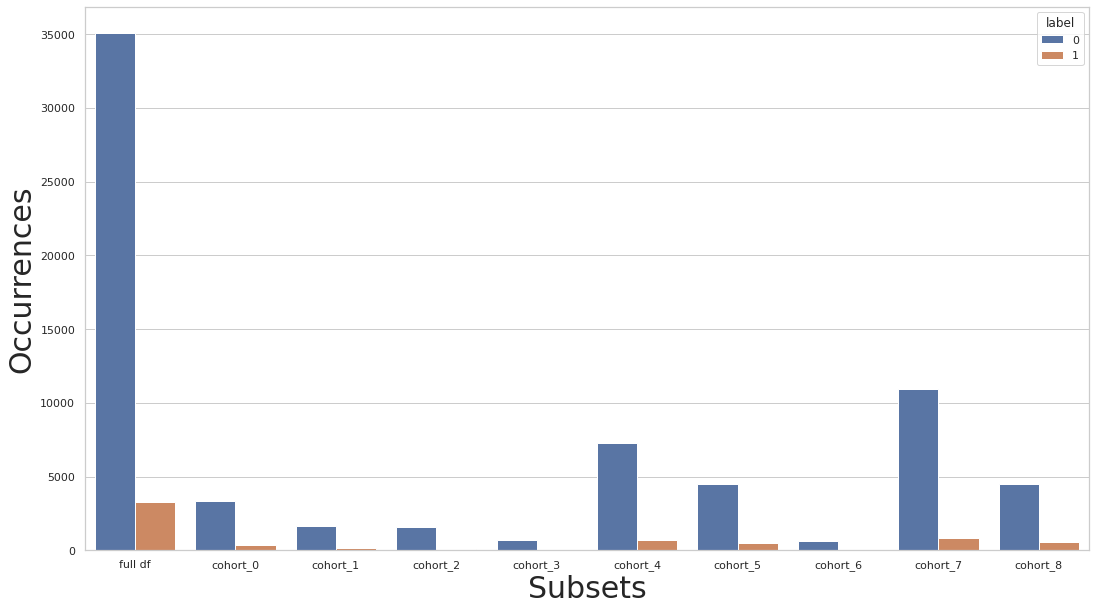

In [54]:
cohort_set = CohortManager(
    cohort_col=["department"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets = cohort_set.get_subsets(X_train, y_train, apply_transform=False)

#print(y_train.value_counts())
#for key in subsets.keys():
#    print(f"\n{key}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(y_train, subsets, normalize=False)

In the following cell, we'll rebalance the entire dataset using the ``Rebalance`` class.

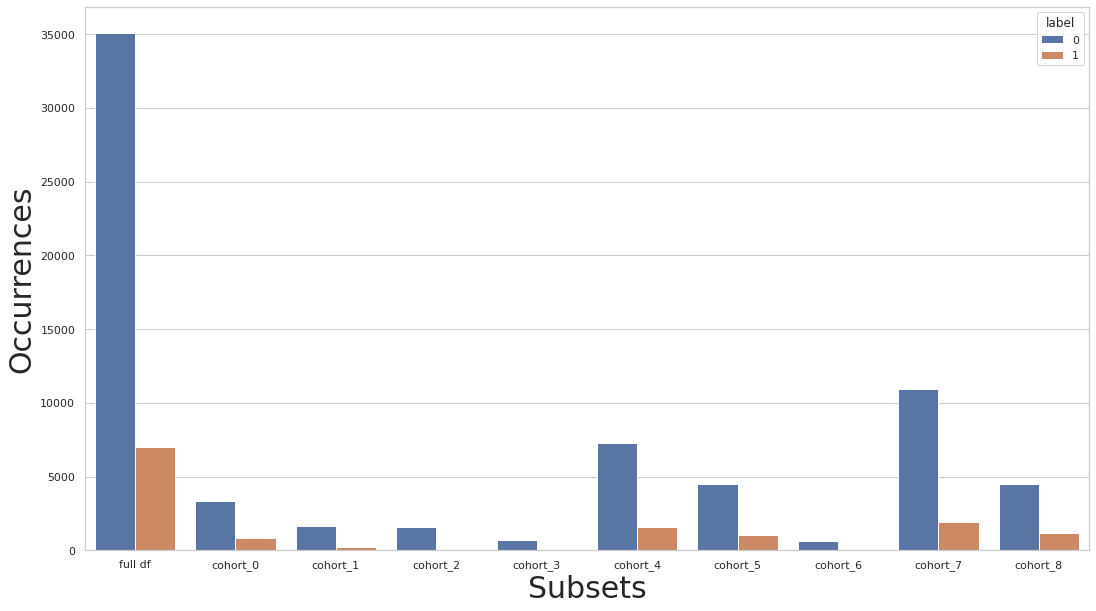

In [55]:
rebalance = dp.Rebalance(strategy_over=0.2, verbose=False)
new_X_train, new_y_train = rebalance.fit_resample(X_train, y_train)

cohort_set.fit(X=new_X_train, y=new_y_train)
subsets = cohort_set.get_subsets(new_X_train, new_y_train, apply_transform=False)

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

With the rebalanced dataset, let's now use our previous cohort-based pipeline using the previously defined cohort definitions over this rebalanced dataset.

In [56]:
c0 = [["department", '==', ['Finance', 'HR', 'R&D', 'Operations', 'Procurement']]]
c1 = [["department", '==', ['Legal']]]
c2 = None

cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_def=[c0, c1, c2]
)
cht_manager.fit(new_X_train, new_y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["department"])

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16443,0.882653,0.115362,0.606043,0.795527,0.600614,0.742626
1,cohort_0,"(`department` == ""Analytics"")",1646,0.713936,0.134958,0.561761,0.673356,0.506832,0.617861
2,cohort_1,"(`department` == ""Finance"")",762,0.897563,0.116745,0.621696,0.814131,0.629498,0.771654
3,cohort_2,"(`department` == ""HR"")",744,0.903948,0.079907,0.594252,0.848901,0.594229,0.778226
4,cohort_3,"(`department` == ""Legal"")",326,0.903537,0.080067,0.648620,0.856592,0.697139,0.907975
5,cohort_4,"(`department` == ""Operations"")",3366,0.879093,0.154786,0.618373,0.782128,0.629625,0.778075
6,cohort_5,"(`department` == ""Procurement"")",2180,0.878716,0.060732,0.602116,0.790458,0.552245,0.648165
7,cohort_6,"(`department` == ""R&D"")",324,0.809061,0.204584,0.568452,0.767961,0.568505,0.799383
8,cohort_7,"(`department` == ""Sales & Marketing"")",5027,0.936626,0.039171,0.625037,0.884295,0.637361,0.792123
9,cohort_8,"(`department` == ""Technology"")",2068,0.843155,0.124896,0.611393,0.768748,0.586957,0.686654


Once again, we got mixed results after rebalancing the dataset when we compare these results with the ones obtained by using a similar cohort-based pipeline over the original dataset. But in the end, the latter managed to attain considerably better results for many cohorts. Given these results, let's try to rebalance the dataset for each ``department`` cohort separately, with the help of the ``CohortManager`` class:

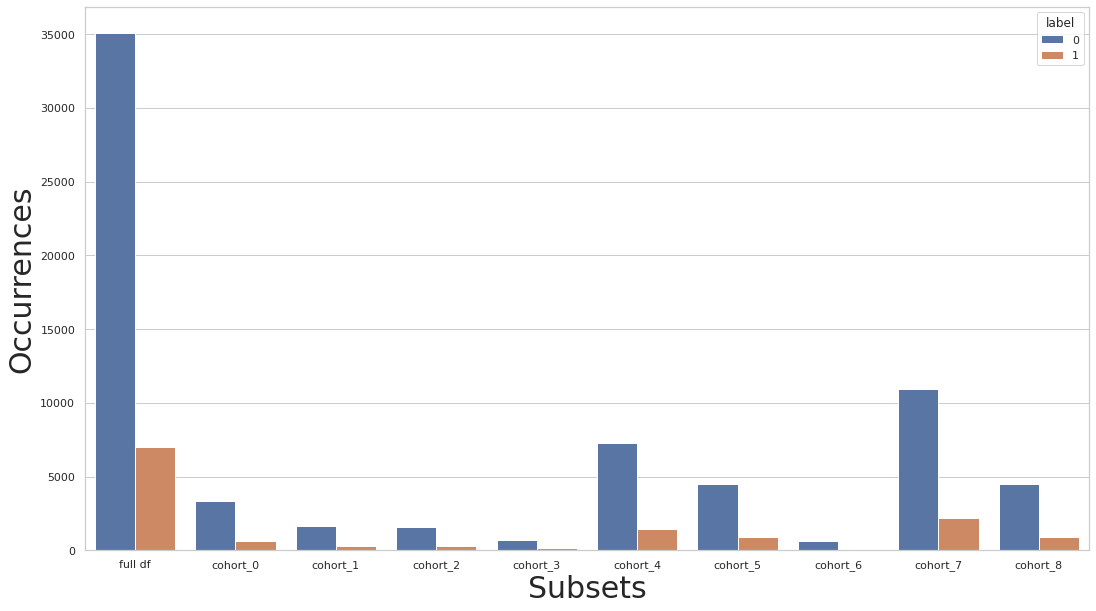

In [57]:
rebalance_cohort = CohortManager(
    transform_pipe=[dp.Rebalance(strategy_over=0.2, verbose=False)],
    cohort_col=["department"]
)
new_X_train, new_y_train = rebalance_cohort.fit_resample(X_train, y_train)

subsets = rebalance_cohort.get_subsets(new_X_train, new_y_train, apply_transform=False)

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

Let's now repeat the same cohort-based pipeline, but this time over the dataset rebalanced for each cohort separately:

In [58]:
c0 = [["department", '==', ['Finance', 'HR', 'R&D', 'Operations', 'Procurement']]]
c1 = [["department", '==', ['Legal']]]
c2 = None

cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_def=[c0, c1, c2]
)
cht_manager.fit(new_X_train, new_y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["department"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16443,0.898558,0.050383,0.602245,0.812015,0.570510,0.689229
1,cohort_0,"(`department` == ""Analytics"")",1646,0.766249,0.141058,0.576293,0.702372,0.549246,0.680437
2,cohort_1,"(`department` == ""Finance"")",762,0.903855,0.209098,0.659268,0.810813,0.694047,0.851706
3,cohort_2,"(`department` == ""HR"")",744,0.920703,0.043647,0.585020,0.853989,0.559841,0.724462
4,cohort_3,"(`department` == ""Legal"")",326,0.879528,0.580881,0.732530,0.847374,0.776444,0.950920
5,cohort_4,"(`department` == ""Operations"")",3366,0.897570,0.093616,0.615737,0.810415,0.608124,0.734700
6,cohort_5,"(`department` == ""Procurement"")",2180,0.911637,0.067863,0.625208,0.836085,0.611378,0.722936
7,cohort_6,"(`department` == ""R&D"")",324,0.828047,0.177297,0.574164,0.820065,0.567199,0.777778
8,cohort_7,"(`department` == ""Sales & Marketing"")",5027,0.935829,0.044099,0.626330,0.883914,0.640559,0.796300
9,cohort_8,"(`department` == ""Technology"")",2068,0.869562,0.050525,0.612508,0.779713,0.570291,0.655706


And once again, we got mixed results when comparing the latest result with the other cohort-based pipelines. This might indicate that rebalancing the dataset is not providing very good results, except for a single cohort: ``cohort_3``. Therefore, we'll perform a third rebalance procedure, but this time, we'll only rebalance the dataset associated to the cohort where ``department`` == "Legal":

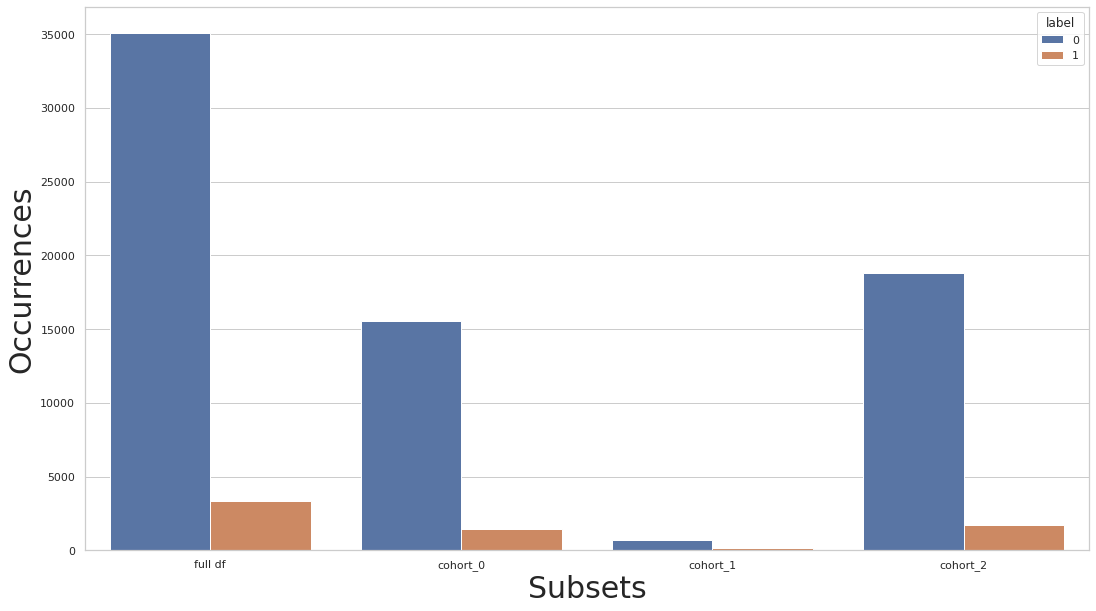

In [59]:
rebalance_cohort = CohortManager(
    transform_pipe=[[], [dp.Rebalance(strategy_over=0.2, verbose=False)], []],
    cohort_def=[c0, c1, c2]
)
new_X_train, new_y_train = rebalance_cohort.fit_resample(X_train, y_train)

subsets = rebalance_cohort.get_subsets(new_X_train, new_y_train, apply_transform=False)

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

In [60]:
c0 = [["department", '==', ['Finance', 'HR', 'R&D', 'Operations', 'Procurement']]]
c1 = [["department", '==', ['Legal']]]
c2 = None

np.random.seed(SEED)
random.seed(SEED)

cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_def=[c0, c1, c2]
)
cht_manager.fit(new_X_train, new_y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["department"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,16443,0.906262,0.078479,0.616146,0.814934,0.618883,0.761540
1,cohort_0,"(`department` == ""Analytics"")",1646,0.780691,0.087622,0.582943,0.723158,0.553528,0.677400
2,cohort_1,"(`department` == ""Finance"")",762,0.917696,0.147653,0.705546,0.833115,0.746577,0.892388
3,cohort_2,"(`department` == ""HR"")",744,0.914903,0.022274,0.583004,0.849715,0.553940,0.716398
4,cohort_3,"(`department` == ""Legal"")",326,0.915756,0.085186,0.651241,0.886710,0.702020,0.904908
5,cohort_4,"(`department` == ""Operations"")",3366,0.903670,0.085596,0.618868,0.803845,0.621463,0.756982
6,cohort_5,"(`department` == ""Procurement"")",2180,0.907424,0.037807,0.624047,0.836303,0.606463,0.715596
7,cohort_6,"(`department` == ""R&D"")",324,0.854369,0.207671,0.607382,0.779935,0.640210,0.882716
8,cohort_7,"(`department` == ""Sales & Marketing"")",5027,0.939642,0.028015,0.624811,0.883088,0.637214,0.792321
9,cohort_8,"(`department` == ""Technology"")",2068,0.884630,0.130006,0.639348,0.799336,0.650063,0.767892


We can see that now we have an improved set of metrics, where we managed to train three different pipelines for the three cohorts being used, where for the second cohort (where ``department`` == "Legal") we also used a rebalance operation, but maintained the training sets for the other cohorts unchanged.

These notebooks aim to highlight the flexibility that the ``CohortManager`` class provides when creating the training pipelines. There are many options that it provides, allowing for complex analysis and operations.